In [1]:
import polaris as po
print(po.__version__)
import numpy as np
import pandas as pd
from rdkit import Chem
import zipfile
import fsspec
import numpy as np
from tqdm import tqdm
import fastpdb
import datamol as dm

from tempfile import TemporaryDirectory
from pathlib import Path
import pymol


from rdkit.Chem import rdFMCS
# calculate rmsd between two molecules
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
import os

/home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.11.7


In [2]:
competition = po.load_competition("asap-discovery/antiviral-ligand-poses-2025")


[2025-02-13 15:56:16] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=819913;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=244596;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.7).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=695267;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=467787;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/dataset/_base.py#182\182]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

In [3]:
# competition.cache()

In [3]:
train, test = competition.get_train_test_split()

In [4]:
# Convert list of tuples to list of dictionaries
data_list = []
for data_dict, rdkit_object in train:
    data_dict['rdkit_object'] = rdkit_object
    data_list.append(data_dict)

# Convert to DataFrame
df = pd.DataFrame(data_list)

In [5]:

df_test = pd.DataFrame(test)

In [6]:
df_test['Protein Label'].value_counts()

Protein Label
SARS-CoV-2 Mpro    98
MERS-CoV Mpro      97
Name: count, dtype: int64

In [7]:
# modify the protein label SARS-CoV-2 Mpro  to SARS-CoV-2-Mpro
df_test['Protein Label'] = df_test['Protein Label'].replace('SARS-CoV-2 Mpro', 'SARS-CoV-2-Mpro')
df_test['Protein Label'] = df_test['Protein Label'].replace('MERS-CoV Mpro', 'MERS-CoV-Mpro')

In [8]:
df_test['Protein Label'].value_counts()

Protein Label
SARS-CoV-2-Mpro    98
MERS-CoV-Mpro      97
Name: count, dtype: int64

In [9]:
# show me index 187
df_test.iloc[187]

Chain A Sequence    SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
Protein Label                                         SARS-CoV-2-Mpro
CXSMILES            CCn1nccc1CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@...
Chain B Sequence    SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
Name: 187, dtype: object

In [10]:
# import yaml

# def create_pocket_yaml(protein_a_sequence, protein_b_sequence, ligand_smiles, output_file):
#     data = {
#         'sequences': [
#             {
#                 'protein': {
#                     'id': ['A1'],
#                     'sequence': protein_a_sequence
#                 }
#             },
#             {
#                 'protein': {
#                     'id': ['B1'],
#                     'sequence': protein_b_sequence
#                 }
#             },
#             {
#                 'ligand': {
#                     'smiles': ligand_smiles,
#                     'id': ['L1']
#                 }
#             }
#         ]
#     }

#     with open(output_file, 'w') as file:
#         yaml.dump(data, file, default_flow_style=False)

In [11]:
yaml_test_folder = Path('./yaml_test')

In [12]:
df_test['MOL'] = df_test['CXSMILES'].apply(Chem.MolFromSmiles)

In [13]:
df_test

,Chain A Sequence,Protein Label,CXSMILES,Chain B Sequence,MOL
0,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV-Mpro,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cn...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f3430626c00>
1,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV-Mpro,COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)cc1,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f3430626030>
2,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2-Mpro,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f3430625e70>
3,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV-Mpro,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f3430625d90>
4,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV-Mpro,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1ccnnc1)C(=O)N(c1c...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f3430625d20>
...,...,...,...,...,...
190,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2-Mpro,CNS(=O)(=O)OCC(=O)N[C@@H](C)c1cc(Cl)cc(-c2ccc(...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f34305321f0>
191,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2-Mpro,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f34305322d0>
192,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV-Mpro,O=C(Cc1cncc2ccccc12)NCc1cccc(Cl)c1,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f3430532340>
193,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2-Mpro,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f34305323b0>


In [14]:
# # Use iterrows on df_test to create the yaml files
# for index, row in df_test.iterrows():
 
#     protein_a_sequence = row['Chain A Sequence']
#     protein_b_sequence = row['Chain B Sequence']
#     ligand_smiles = dm.to_smiles(row['MOL'])
    
#     output_file =  yaml_test_folder / f'seq_{index}.yaml'
#     print(output_file)
#     create_pocket_yaml(protein_a_sequence, protein_b_sequence, ligand_smiles, output_file)

In [15]:
source = Path("./")
predicted = Path("./boltz_results_train_fasta/predictions")
reference = Path("./reference_structures")
ligand_output = Path("./ligand_output")

In [49]:
# def create_fasta_file(df, dir_name):
#     os.makedirs(dir_name, exist_ok=True)
#     for i, row in df.iterrows():
  
#         chain_a = row['Chain A Sequence']
#         chain_b = row['Chain B Sequence']
#         chain_cx = dm.to_smiles(row['MOL'])
       
#         with open(f"{dir_name}/seq_{i}.fasta", "w") as f:
#             f.write(f">A|protein|\n{chain_a}\n")
#             f.write(f">B|protein|\n{chain_b}\n")
#             f.write(f">E|smiles\n{chain_cx}\n")
            
# create_fasta_file(df_test, "test_fasta")


In [122]:
def pymol_align(index, row):
    # Let's reset! Just to be sure.
    pymol.cmd.delete("all")

    # Load the reference and mobile structure
    # ref_path = reference / f"complex_{index}.pdb"
    ref_path = reference / row['Protein Label'] / "complex.pdb"
    print(ref_path)
    target_path = predicted / f'seq_{index}' / f'seq_{index}_model_0.cif'
    print(target_path)
    pymol.cmd.load(target_path, "predicted")
    pymol.cmd.load(ref_path, "reference")

    # Corrupt the mobile protein
    # pymol.cmd.rotate("x", 90, selection="mobile")
    # Compute the RMSD

    # Align the mobile protein to the reference
    pymol.cmd.align(
    "polymer and name CA and predicted",
    "polymer and name CA and reference",
    quiet=0,
    )
 
    pymol.cmd.select('ligands_predicted', 'predicted and not polymer')

  

    # Export the ligand as a Mol2 file (or any other format RDKit can read)
    pymol.cmd.save(ligand_output / f'ligand_{index}.mol2', 'ligands_predicted')


# def ligand_compare(index):
#     # Get the Reference from df
#     ref_ligand = df.iloc[index]['rdkit_object']
#     ref_ligand = Chem.RemoveHs(ref_ligand)
    
#     # Get the Predicted ligand from Pymol
#     pred_ligand = Chem.MolFromMol2File(ligand_output / f'ligand_{index}.mol2')
#     pred_ligand = Chem.RemoveHs(pred_ligand)
    
#     mols = [ref_ligand, pred_ligand]
#     mcs =rdFMCS.FindMCS(mols,threshold=0.8,completeRingsOnly=True,ringMatchesRingOnly=True)
#     # align everything to the first molecule
#     patt = Chem.MolFromSmarts(mcs.smartsString)
#     refMol = mols[0]
#     refMatch = refMol.GetSubstructMatch(patt)
    
 
#     mv = pred_ligand.GetSubstructMatch(patt)
#     rms = AllChem.CalcRMS(pred_ligand,refMol,map=[list(zip(mv,refMatch))])
#     return rms
    
    
    
  





  
    
    

In [115]:
#  do iter rows in df_test
for i, row in df_test.iterrows():
    try:
        pymol_align(i, row)
    except:
        continue
    # rms = ligand_compare(i)
    # print(f"RMSD for {i} is {rms}")

reference_structures/MERS-CoV-Mpro/complex.pdb
boltz_results_train_fasta/predictions/seq_0/seq_0_model_0.cif
 Match: read scoring matrix.
 Match: assigning 608 x 602 pairwise scores.
 MatchAlign: aligning residues (608 vs 602)...
 MatchAlign: score 1603.000
 ExecutiveAlign: 592 atoms aligned.
 ExecutiveRMS: 33 atoms rejected during cycle 1 (RMSD=2.16).
 ExecutiveRMS: 33 atoms rejected during cycle 2 (RMSD=1.44).
 ExecutiveRMS: 30 atoms rejected during cycle 3 (RMSD=1.18).
 ExecutiveRMS: 23 atoms rejected during cycle 4 (RMSD=1.03).
 ExecutiveRMS: 17 atoms rejected during cycle 5 (RMSD=0.93).
 Executive: RMSD =    0.864 (456 to 456 atoms)
reference_structures/MERS-CoV-Mpro/complex.pdb
boltz_results_train_fasta/predictions/seq_1/seq_1_model_0.cif
 Match: read scoring matrix.
 Match: assigning 608 x 602 pairwise scores.
 MatchAlign: aligning residues (608 vs 602)...
 MatchAlign: score 1603.000
 ExecutiveAlign: 592 atoms aligned.
 ExecutiveRMS: 34 atoms rejected during cycle 1 (RMSD=2.18).

In [55]:
import base64
from rdkit import Chem


def serialize_rdkit_mol(mol: Chem.Mol): 
    props = Chem.PropertyPickleOptions.AllProps
    mol_bytes = mol.ToBinary(props)
    return base64.b64encode(mol_bytes).decode('ascii')  


# y_pred_serialized = [serialize_rdkit_mol(mol) for mol in y_pred]

In [117]:
mol = []
# read all molecules in ligand output
for i in range(195):
    try:
        mol.append(Chem.MolFromMol2File(ligand_output / f'ligand_{i}.mol2', sanitize=False))
    except:
        mol.append(None)
    

[12:06:18] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[12:06:18] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[12:06:18] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[12:06:18] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[12:06:18] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[12:06:18] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[12:06:18] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[12:06:18] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[12:06:18] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[12:06:18] predicted: Warnin

In [28]:
sars = Chem.SDMolSupplier("sars_minimized_ligands.sdf",sanitize=False)
mers = Chem.SDMolSupplier("mers_minimized_output.sdf",sanitize=False)

In [29]:
# SARS-CoV-2-Mpro find indices in df _testi
s_index = df_test[df_test["Protein Label"] == "SARS-CoV-2-Mpro"].index
m_index = df_test[df_test["Protein Label"] == "MERS-CoV-Mpro"].index

In [30]:
mols_with_proper_index = {}

In [31]:
for index, molindex in enumerate(s_index):
    mols_with_proper_index[f'ligand_{molindex}'] = sars[index]

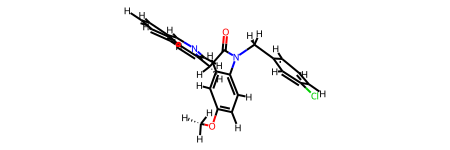

In [32]:
for index, molindex in enumerate(m_index):
    mols_with_proper_index[f'ligand_{molindex}'] = mers[index]
    
mols_with_proper_index['ligand_1']

In [33]:
# sort dictionary by key
mols_with_proper_index = dict(sorted(mols_with_proper_index.items()))

In [35]:
df_test

,Chain A Sequence,Protein Label,CXSMILES,Chain B Sequence,MOL
0,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV-Mpro,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cn...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f3430626c00>
1,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV-Mpro,COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)cc1,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f3430626030>
2,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2-Mpro,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f3430625e70>
3,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV-Mpro,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f3430625d90>
4,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV-Mpro,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1ccnnc1)C(=O)N(c1c...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f3430625d20>
...,...,...,...,...,...
190,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2-Mpro,CNS(=O)(=O)OCC(=O)N[C@@H](C)c1cc(Cl)cc(-c2ccc(...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f34305321f0>
191,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2-Mpro,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f34305322d0>
192,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV-Mpro,O=C(Cc1cncc2ccccc12)NCc1cccc(Cl)c1,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f3430532340>
193,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2-Mpro,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f34305323b0>


In [36]:
# add a empty column to df_test
df_test['Predicted Pose'] = np.nan

In [39]:
# go through each row in df_test and add the predicted pose
for index, row in df_test.iterrows():

    df_test.at[index, 'Predicted Pose'] = mols_with_proper_index[f'ligand_{index}']

/tmp/ipykernel_467488/4265409299.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<rdkit.Chem.rdchem.Mol object at 0x7f3429661000>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.at[index, 'Predicted Pose'] = mols_with_proper_index[f'ligand_{index}']


In [45]:
df_test['match'] = df_test.apply(lambda x: dm.same_mol(x['MOL'], x['Predicted Pose']), axis=1)

[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[16:04:28] tetra

In [47]:
df_test['match'].value_counts()

match
True     134
False     61
Name: count, dtype: int64

In [49]:
# what is iundex of all failed matches
df_test[df_test['match'] == False].index

Index([  3,  10,  11,  12,  18,  19,  22,  24,  25,  31,  32,  33,  35,  36,
        40,  44,  47,  49,  50,  52,  54,  56,  57,  58,  61,  68,  75,  77,
        78,  88,  89,  92,  95, 107, 108, 111, 115, 116, 127, 128, 131, 132,
       134, 135, 136, 138, 142, 147, 151, 154, 155, 163, 170, 171, 175, 178,
       179, 185, 186, 188, 194],
      dtype='int64')

In [56]:
y_pred_serialized = [serialize_rdkit_mol(mol) for mol in df_test['Predicted Pose'].values]

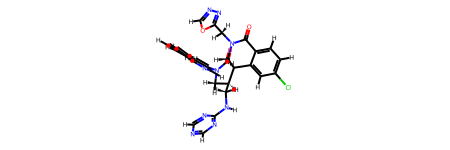

In [57]:
deserialized = Chem.Mol(base64.b64decode(y_pred_serialized[0].encode("ascii")))
deserialized

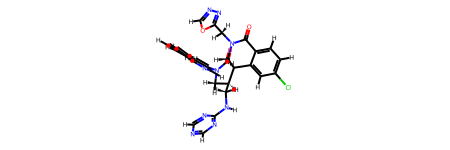

In [58]:
df_test['Predicted Pose'][0]

In [59]:
dm.same_mol(df_test['Predicted Pose'][0], deserialized)

True

In [61]:
df_test['ref heavy atoms'] = df_test['MOL'].apply(lambda x: x.GetNumHeavyAtoms())
df_test['pred heavy atoms'] = df_test['Predicted Pose'].apply(lambda x: x.GetNumHeavyAtoms())


In [62]:
df_test['num heavy atomns diff'] = df_test['ref heavy atoms'] - df_test['pred heavy atoms']

In [67]:
df_test['num heavy atomns diff'] = df_test['num heavy atomns diff'].astype(int)
df_test['num heavy atomns diff'].value_counts()

num heavy atomns diff
0    195
Name: count, dtype: int64

In [60]:
competition.submit_predictions(
    predictions=y_pred_serialized,
    prediction_name="Pose-Prediction-Fix-1",
    prediction_owner="auro",
    report_url="https://www.example.com", 
    # The below metadata is optional, but recommended.
    # github_url="https://github.com/polaris-hub/polaris",
    description="Pose prediction using Open source model as a starting checkpoint and compare performance. Addressed issues for most of the poses.",
    # tags=["tutorial"],
    # user_attributes={"Framework": "RDKit", "Method": "Dummy Baseline"}
)

/home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[16:10:02]  Success: Submitting competition predictions                                               ]8;id=781093;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=759156;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

In [69]:
# move the first ligand_i files from train_fasta to anothr folder
for i in range(100):
    try:
        os.rename( f'train_fasta/seq_{i}.fasta',  f'train_fasta_subset/seq_{i}.fasta')
    except:
        print(f"file {i} not found")